In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import pickle

# Load Data

In [2]:
import os, re
import pandas as pd

def load_raw_data(root_dir, sensors=("Accelerometer", "Gravity", "Gyroscope")):
    """
    Load raw sensor data into a nested dictionary.

    Structure:
        data[activity][trial][student][sensor] = DataFrame

    Folder naming convention:
        "{Activity}_{trial}_{student}"
        e.g. "Sit_1_Student1"

    Parameters
    ----------
    root_dir : str
        Root directory containing activity folders.
    sensors : tuple of str
        Sensor names to load (case-sensitive, must match CSV filenames).

    Returns
    -------
    dict
        Nested dictionary with DataFrames.
    """

    data = {}

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        # Match folder name pattern
        match = re.match(r"([A-Za-z]+)_(\d+)_([A-Za-z0-9]+)", folder)
        if not match:
            print(f"[load_raw_data] Skipping {folder} (unexpected name format)")
            continue

        activity, trial, student = match.groups()

        # Initialize nested dicts
        data.setdefault(activity, {}).setdefault(trial, {}).setdefault(student, {})

        # Load each sensor file if it exists
        for sensor in sensors:
            file_path = os.path.join(folder_path, f"{sensor}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                data[activity][trial][student][sensor.lower()] = df
            else:
                print(f"[load_raw_data] Missing {file_path}")

    return data


In [3]:
data = load_raw_data("Raw Data")

# Save the data dictionary to a pickle file
with open("data.pkl", "wb") as f:
    pickle.dump(data, f)

In [4]:
data["Stand"]["1"]["Student1"]["accelerometer"]   

,time,seconds_elapsed,z,y,x
0,1759157627659409400,0.019409,0.012783,0.107280,-0.044314
1,1759157627669467400,0.029467,0.029959,0.081197,-0.053373
2,1759157627679524400,0.039524,0.003599,0.138549,-0.037378
3,1759157627689581800,0.049582,-0.013361,0.171658,-0.031640
4,1759157627699639800,0.059640,0.013671,0.143785,-0.015338
...,...,...,...,...,...
533,1759157633020415700,5.380416,-0.206405,0.141028,-0.276440
534,1759157633030474000,5.390474,-0.187276,-0.070544,-0.314168
535,1759157633040532700,5.400533,-0.111666,-0.108651,-0.326882
536,1759157633050590700,5.410591,-0.048610,-0.034493,-0.259095


# 1) Data Preprocessing Pipeline

1) Combine sensor data together

2) Trimming

3) Windowing 

4) Saving

In [5]:
import pandas as pd

SENSOR_PREFIX_MAP = {
    "accelerometer": "acc",
    "gyroscope": "gyro",
    "gravity": "grav",
}

def _sensor_prefix(sensor_key: str) -> str:
    s = sensor_key.lower()
    for k, v in SENSOR_PREFIX_MAP.items():
        if s.startswith(k[:3]):  # acc, gyr, gra
            return v
    return s

def combine_sensors_first(
    data,
    time_col_candidates=("seconds_elapsed", "time"),
    require_equal_length=True,
    keep_time=True
):
    """
    Convert:
        data[activity][trial][student][sensor] = DataFrame
    into:
        combined[activity][trial][student] = DataFrame  (columns: time?, acc_*, gyro_*, grav_*)

    Assumes sensors share the same timestamps/order. If `require_equal_length` is True,
    mismatched lengths raise an AssertionError.
    """
    def _time_cols(df):
        return [c for c in time_col_candidates if c in df.columns]

    combined = {}
    for activity, trials in data.items():
        combined[activity] = {}
        for trial, students in trials.items():
            combined[activity][trial] = {}
            for student, sensors in students.items():
                # Collect available sensor DFs
                sensor_items = [(s, df) for s, df in sensors.items() if isinstance(df, pd.DataFrame) and not df.empty]
                if not sensor_items:
                    combined[activity][trial][student] = pd.DataFrame()
                    continue

                # Optionally check equal lengths
                lens = {s: len(df) for s, df in sensor_items}
                if require_equal_length and len(set(lens.values())) != 1:
                    raise AssertionError(f"Different lengths at {activity}/{trial}/{student}: {lens}")

                # Build parts: one time column + prefixed feature cols
                parts = []
                time_added = False
                for s, df in sorted(sensor_items, key=lambda x: x[0]):  # stable order
                    tcols = _time_cols(df)
                    # Add time once
                    if keep_time and not time_added and tcols:
                        parts.append(df[tcols[0]].reset_index(drop=True))
                        time_added = True
                    # Add features with sensor prefix
                    non_time = [c for c in df.columns if c not in set(tcols)]
                    if non_time:
                        pref = _sensor_prefix(s)
                        renamed = {c: f"{pref}_{c.lower()}" for c in non_time}
                        parts.append(df[non_time].rename(columns=renamed).reset_index(drop=True))

                combined_df = pd.concat(parts, axis=1) if parts else pd.DataFrame()
                combined[activity][trial][student] = combined_df

    return combined


In [6]:
# To drop time columns after windowing
TIME_COL_CANDS = ["seconds_elapsed", "time"]

def _get_time_col(df):
    """
    Return the first matching time column from TIME_COL_CANDS.
    Assumes at least one of them is present.
    """
    for col in TIME_COL_CANDS:
        if col in df.columns:
            return col
    raise ValueError("No valid time column found. Expected one of: " + ", ".join(TIME_COL_CANDS))


def _crop_segment(df, start_offset_s, duration_s, time_col, hz=100.0):
    """
    For activities like Sit/Stand:
    Take a fixed segment starting at row index corresponding to start_offset_s * hz
    and keep exactly duration_s * hz samples (index-based, like window_all_100hz).

    Parameters
    ----------
    df : pd.DataFrame
    start_offset_s : float
        Offset in seconds from the *first row* of df.
    duration_s : float
        Desired window length in seconds.
    time_col : str
        Unused for filtering here (kept for API consistency).
    hz : float
        Assumed sampling rate (default 100.0 Hz).

    Returns
    -------
    pd.DataFrame
        Cropped DataFrame with reset index; empty if not enough rows.
    """
    if df is None or df.empty:
        return df

    n_off = int(round(float(start_offset_s) * float(hz)))
    n_win = int(round(float(duration_s) * float(hz)))
    if n_off < 0 or n_win <= 0:
        return df.iloc[0:0].reset_index(drop=True)

    start_idx = n_off
    end_idx = start_idx + n_win

    if start_idx >= len(df) or end_idx <= 0:
        return df.iloc[0:0].reset_index(drop=True)

    # Clamp to available range
    start_idx = max(0, start_idx)
    end_idx = min(len(df), end_idx)

    # If the clamped slice is shorter than requested window, return empty (strict)
    if end_idx - start_idx < n_win:
        return df.iloc[0:0].reset_index(drop=True)

    return df.iloc[start_idx:end_idx].reset_index(drop=True)


def _crop_trim(df, start_trim_s, end_trim_s, time_col):
    """
    For other activities:
    Trim 'start_trim_s' seconds from the beginning,
    and 'end_trim_s' seconds from the end of the recording.
    """
    t_min, t_max = float(df[time_col].min()), float(df[time_col].max())
    start_bound = t_min + float(start_trim_s)
    end_bound   = t_max - float(end_trim_s)
    # Guard: if trims remove the whole range, return empty DataFrame
    if start_bound >= end_bound:
        return df.iloc[0:0].reset_index(drop=True)
    return df[(df[time_col] >= start_bound) & (df[time_col] <= end_bound)].reset_index(drop=True)

def crop_mixed_combined(
    data_combined,
    sit_stand_start_offset_s=1.5,
    window_size_s=2.0,
    trims_start=None,
    trims_end=None,
    sit_stand_set=("Sit", "Stand"),
    hz=100.0,
    verbose=False
):
    """
    Input:
        data_combined[activity][trial][student] = DataFrame (time + all sensor cols)
    Output:
        cropped[activity][trial][student] = DataFrame (cropped)
    """
    if trims_start is None: trims_start = 2.0
    if trims_end   is None: trims_end   = 2.0

    def _resolve(activity, val):
        return val.get(activity, val.get(activity.capitalize(), 0)) if isinstance(val, dict) else val

    cropped = {}
    for activity, trials in data_combined.items():
        cropped[activity] = {}
        for trial, students in trials.items():
            cropped[activity][trial] = {}
            for student, df in students.items():
                if not isinstance(df, pd.DataFrame) or df.empty:
                    cropped[activity][trial][student] = df
                    if verbose:
                        print(f"[crop_mixed_combined] Empty: {activity}-{trial}-{student}")
                    continue

                # detect time col if present
                try:
                    tcol = _get_time_col(df)
                except ValueError:
                    tcol = None  # allow time-less data if you already index by samples

                if activity in sit_stand_set:
                    # fixed-length segment by sample count (uses hz)
                    if tcol is None:
                        # no time column needed for count-based crop
                        out = _crop_segment(df, sit_stand_start_offset_s, window_size_s, time_col="", hz=hz)
                    else:
                        out = _crop_segment(df, sit_stand_start_offset_s, window_size_s, tcol, hz=hz)
                else:
                    if tcol is None:
                        # fall back: trim by samples if no time
                        n0 = int(round(_resolve(activity, trims_start) * hz))
                        n1 = int(round(_resolve(activity, trims_end) * hz))
                        if n0 + n1 >= len(df):
                            out = df.iloc[0:0].reset_index(drop=True)
                        else:
                            out = df.iloc[n0:len(df)-n1].reset_index(drop=True)
                    else:
                        # trim by time bounds
                        s_trim = _resolve(activity, trims_start)
                        e_trim = _resolve(activity, trims_end)
                        out = _crop_trim(df, s_trim, e_trim, tcol)

                cropped[activity][trial][student] = out

    return cropped


In [7]:
def window_all_100hz_combined(
    data_combined,
    window_size_s=2.0,
    step_s=None,
    keep_time_col=True,  # keep time since you combined early
    time_col_candidates=("seconds_elapsed", "time")
):
    """
    Input:
        data_combined[activity][trial][student] = DataFrame
    Output:
        windows[activity][trial][student] = [DataFrame, ...]
    """
    HZ = 100.0
    if step_s is None:
        step_s = window_size_s

    n_win = int(round(window_size_s * HZ))
    n_stp = int(round(step_s * HZ))
    if n_win <= 0 or n_stp <= 0:
        raise ValueError("window_size_s and step_s must be > 0.")

    def _drop_time(df):
        drops = [c for c in time_col_candidates if c in df.columns]
        return df.drop(columns=drops) if (not keep_time_col and drops) else df

    def _make_windows(df):
        if df is None or df.empty: return []
        N = len(df)
        last_start = N - n_win
        if last_start < 0: return []
        out = []
        for s in range(0, last_start + 1, n_stp):
            e = s + n_win
            out.append(_drop_time(df.iloc[s:e].copy()).reset_index(drop=True))
        return out

    windows = {}
    for activity, trials in data_combined.items():
        windows[activity] = {}
        for trial, students in trials.items():
            windows[activity][trial] = {}
            for student, df in students.items():
                windows[activity][trial][student] = _make_windows(df)
    return windows


In [8]:
def save_windows_simple(
    windows,
    out_dir="windows_out"
):
    """
    Input:
        windows[activity][trial][student] = [DataFrame_win0, ...]
    """
    os.makedirs(out_dir, exist_ok=True)
    index_rows = []

    for activity, trials in windows.items():
        for trial, students in trials.items():
            for student, win_list in students.items():
                for i, wdf in enumerate(win_list):
                    rel = f"{activity}/trial_{trial}/{student}/win_{i}.csv"
                    path = os.path.join(out_dir, rel)
                    os.makedirs(os.path.dirname(path), exist_ok=True)
                    wdf.to_csv(path, index=False)
                    index_rows.append({
                        "activity": activity,
                        "trial": trial,
                        "student": student,
                        "window_idx": i,
                        "path": path
                    })

    idx = pd.DataFrame(index_rows)
    idx.to_csv(os.path.join(out_dir, "index.csv"), index=False)
    return idx


In [9]:
# 1) Combine sensors first
combined = combine_sensors_first(
    data,
    time_col_candidates=("seconds_elapsed", "time"),
    require_equal_length=True,
    keep_time=True
)

# 2) Crop differently by activity on the combined DF
cropped = crop_mixed_combined(
    combined,
    sit_stand_start_offset_s=1.0,
    window_size_s=2.0,
    trims_start={"Running": 2, "Walking": 2, "Stairs": 2, "Stand": 0, "Sit": 0},
    trims_end={"Running": 2, "Walking": 2, "Stairs": 2, "Stand": 0, "Sit": 0},
    sit_stand_set=("Sit", "Stand"),
    hz=100.0,
    verbose=True
)

# 3) Window the combined DF
win = window_all_100hz_combined(
    cropped,
    window_size_s=2.0,
    step_s=2.0,
    keep_time_col=True
)

# 4) Save one CSV per window
inventory = save_windows_simple(win, out_dir="windows")
print("Saved windows:", len(inventory), "→ index at:", "windows/index.csv")


Saved windows: 121 → index at: windows/index.csv


In [10]:
import matplotlib.pyplot as plt

def plot_window(window_df, activity_name="Activity"):
    """
    Plot x, y, z vs time for each sensor in a combined window DataFrame.
    Expects columns like: time, acc_x/acc_y/acc_z, gyro_x/gyro_y/gyro_z, grav_x/grav_y/grav_z
    """
    # time column
    tcol = "time" if "time" in window_df.columns else "seconds_elapsed"
    t = window_df[tcol]

    # map prefixes to nice names
    prefix_map = {
        "acc": "Accelerometer",
        "gyro": "Gyroscope",
        "grav": "Gravity"
    }

    # find which sensors exist in this DF
    sensors_present = [p for p in prefix_map if f"{p}_x" in window_df.columns]

    fig, axes = plt.subplots(len(sensors_present), 1, figsize=(7, 3*len(sensors_present)), sharex=True)
    if len(sensors_present) == 1:
        axes = [axes]

    fig.suptitle(activity_name, fontsize=14)

    for ax, pref in zip(axes, sensors_present):
        ax.plot(t, window_df[f"{pref}_x"], label="x")
        ax.plot(t, window_df[f"{pref}_y"], label="y")
        ax.plot(t, window_df[f"{pref}_z"], label="z")
        ax.set_ylabel(prefix_map[pref])
        ax.legend(loc="upper right")

    axes[-1].set_xlabel(tcol)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [11]:

# Save the win dictionary to a pickle file
with open("win.pkl", "wb") as f:
    pickle.dump(win, f)


In [12]:
#with open("win.pkl", "rb") as f:
    #win = pickle.load(f)

In [13]:
win

{'Running': {'1': {'Student1': [     seconds_elapsed      acc_z      acc_y      acc_x    grav_z    grav_y  \
    0           2.042597   2.007656  -0.379823  -1.020999 -1.837967 -9.389118   
    1           2.052656   2.769082  -0.209722  -0.277282 -1.859885 -9.380701   
    2           2.062715   2.720869  -0.174290  -0.076689 -1.869729 -9.373188   
    3           2.072774   2.596583   0.020212   0.092764 -1.870093 -9.366427   
    4           2.082833   2.444855   0.151780   0.039554 -1.861867 -9.360928   
    ..               ...        ...        ...        ...       ...       ...   
    195         4.004102 -15.946595 -23.524595  -2.007820 -1.335800 -9.422015   
    196         4.014161  -9.086429 -27.050693  -5.651480 -1.869587 -9.287151   
    197         4.024220   9.676047 -27.950930  -9.956111 -2.293227 -9.124182   
    198         4.034279  16.712898 -26.318082 -19.558102 -2.493136 -8.976041   
    199         4.044338  14.844593 -20.064469 -20.821329 -2.479289 -8.853447   


In [14]:
win['Running']['2']['Student1'][3]

,seconds_elapsed,acc_z,acc_y,acc_x,grav_z,grav_y,grav_x,gyro_z,gyro_y,gyro_x
0,8.069215,2.094147,14.481539,2.730723,1.621504,-9.670391,0.156983,1.304815,1.439138,-0.319605
1,8.079273,0.046347,11.214355,-1.060753,1.568243,-9.680420,-0.021576,1.837550,1.653007,-0.813076
2,8.089331,-2.122630,7.906404,-4.154830,1.461680,-9.694124,-0.240476,2.086752,1.615628,-1.305474
3,8.099389,-3.524599,6.585646,-4.038277,1.320288,-9.706637,-0.456538,1.858064,1.301240,-1.448754
4,8.109448,-2.579598,6.766122,-2.354473,1.175399,-9.715479,-0.631097,1.419656,1.190439,-1.368358
...,...,...,...,...,...,...,...,...,...,...
195,10.030513,0.835998,7.661061,-7.195777,0.111507,-9.297498,3.116805,1.666097,0.515538,2.806059
196,10.040572,-2.514768,5.331145,-8.465742,0.355797,-9.347418,2.944414,2.026302,-1.045600,2.457504
197,10.050630,-5.933398,3.510988,-10.128516,0.480604,-9.403119,2.742404,2.465794,-3.020276,1.357911
198,10.060687,-8.204999,-0.802782,-12.114159,0.493574,-9.471337,2.494107,3.173332,-3.523696,0.991187


In [15]:
win.keys()

dict_keys(['Running', 'Sit', 'Stairs', 'Stand', 'Walking'])

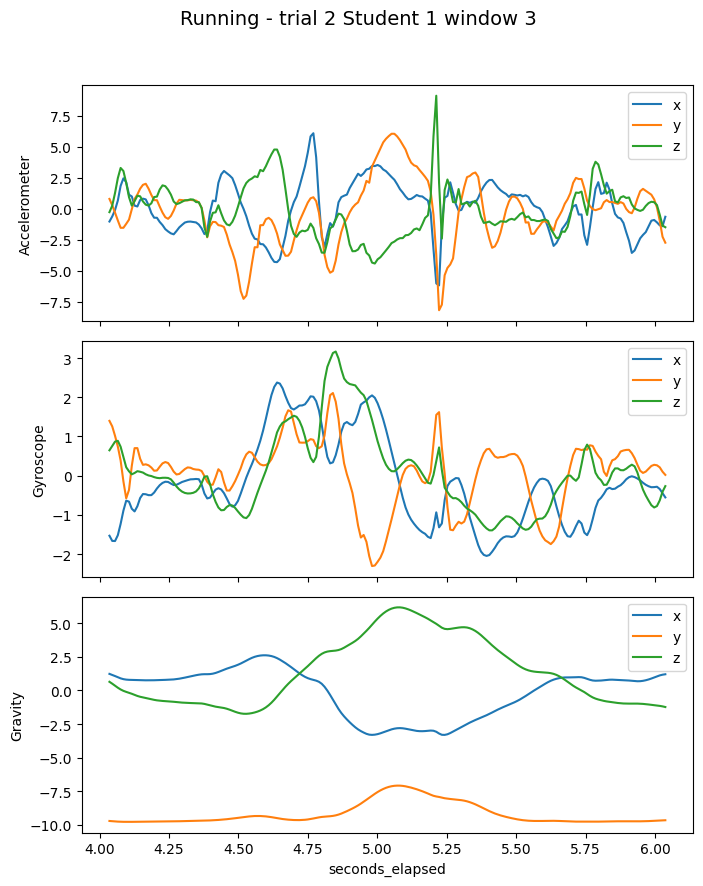

In [16]:
plot_window(win["Stairs"]["2"]["Student1"][1], activity_name="Running - trial 2 Student 1 window 3")


In [17]:
# Load the index file created by save_windows
idx = pd.read_csv("windows/index.csv")

# Count windows per activity
counts = idx.groupby("activity")["window_idx"].count().reset_index(name="num_windows")

print(counts)

  activity  num_windows
0  Running           18
1      Sit           20
2   Stairs           20
3    Stand           20
4  Walking           43


## Features

### List of features

- Time domain:
    - per axis for each sensor:
        - mean
        - median
        - std
        - var
        - min
        - max
        - range
        - rmn (root mean square)
        - mad (median absolute deviation)
        - iqr (interquartile range)
        - skew (distribution skewness)
        - kurt (kurtosis, peakedness)
    - per sensor:
        - sma (signal magnitude area = mean(|x|+|y|+|z|))
    - per sensor correlations

- Frequency domain:
    - per axis for each sensor:
        - dominant frequency
        - dominant magnitude
        - average spectral energy
        - spectral entropy

### Calculating Features

In [18]:
data

{'Running': {'1': {'Student1': {'accelerometer':                      time  seconds_elapsed         z         y         x
    0     1759158616638895600         0.040896 -0.165525 -0.013971 -0.128877
    1     1759158616648954400         0.050954 -0.155381  0.070200 -0.084560
    2     1759158616659012600         0.061013 -0.136026  0.144623 -0.015030
    3     1759158616669071400         0.071071 -0.229045  0.141181 -0.036587
    4     1759158616679130600         0.081131 -0.273716  0.098258 -0.069132
    ...                   ...              ...       ...       ...       ...
    1298  1759158629695364400        13.097364 -0.127062 -0.286627  0.053590
    1299  1759158629705423400        13.107423 -0.295709 -0.251304 -0.027278
    1300  1759158629715482400        13.117482 -0.243986 -0.033014  0.049334
    1301  1759158629725541400        13.127541  0.302864  0.040080  0.159224
    1302  1759158629735599600        13.137600  0.702105 -0.044975  0.151024
    
    [1303 rows x 5 columns

In [19]:
data.keys()

dict_keys(['Running', 'Sit', 'Stairs', 'Stand', 'Walking'])

In [20]:
win.keys()

dict_keys(['Running', 'Sit', 'Stairs', 'Stand', 'Walking'])

In [21]:
import os
import re
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# ------------------ Feature helpers (no band powers) ------------------
FS = 100.0
TIME_COLS = {"seconds_elapsed", "time"}

def _drop_time_cols(df):
    drop = [c for c in df.columns if c in TIME_COLS]
    return df.drop(columns=drop) if drop else df

def _find_axes(df):
    lower = {c.lower(): c for c in df.columns}
    def pick(axis):
        if axis in lower: return lower[axis]
        for c in df.columns:
            lc = c.lower()
            if lc == axis or lc.startswith(axis) or axis in lc:
                return c
        return None
    return pick("x"), pick("y"), pick("z")

def _iqr(x):  return float(np.subtract(*np.percentile(x, [75, 25]))) if x.size else np.nan
def _mad(x):
    if x.size == 0: return np.nan
    med = np.median(x); return float(np.median(np.abs(x - med)))
def _rms(x): return float(np.sqrt(np.mean(x.astype(float)**2))) if x.size else np.nan

def _dom_freq_and_mag(x, fs=FS):
    n = x.size
    if n == 0: return np.nan, np.nan
    x = x.astype(float) - np.mean(x)
    X = np.fft.rfft(x, n=n)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    amp = np.abs(X) / n
    if amp.size > 0: amp[0] = 0.0
    k = int(np.argmax(amp))
    return float(freqs[k]), float(amp[k])

def _spectral_energy_entropy(x, fs=FS):
    n = x.size
    if n == 0: return {"spec_energy": np.nan, "spec_entropy": np.nan}
    x = x.astype(float) - np.mean(x)
    X = np.fft.rfft(x, n=n)
    power = (np.abs(X)**2) / n
    power[0] = 0.0
    total_p = np.sum(power) + 1e-12
    p_norm = power / total_p
    return {
        "spec_energy": float(total_p / n),
        "spec_entropy": float(-np.sum(p_norm * np.log(p_norm + 1e-12)))
    }

def _sma(x, y=None, z=None):
    parts = [a for a in (x, y, z) if a is not None]
    if not parts: return np.nan
    S = np.zeros_like(parts[0], dtype=float)
    for a in parts: S += np.abs(a.astype(float))
    return float(np.mean(S))

def _axis_features(x, prefix):
    x = np.asarray(x).astype(float)
    feats = {
        f"{prefix}_mean":   float(np.mean(x)) if x.size else np.nan,
        f"{prefix}_median": float(np.median(x)) if x.size else np.nan,
        f"{prefix}_std":    float(np.std(x, ddof=1)) if x.size>1 else (0.0 if x.size==1 else np.nan),
        f"{prefix}_var":    float(np.var(x, ddof=1)) if x.size>1 else (0.0 if x.size==1 else np.nan),
        f"{prefix}_min":    float(np.min(x)) if x.size else np.nan,
        f"{prefix}_max":    float(np.max(x)) if x.size else np.nan,
        f"{prefix}_range":  float(np.max(x)-np.min(x)) if x.size else np.nan,
        f"{prefix}_rms":    _rms(x),
        f"{prefix}_mad":    _mad(x),
        f"{prefix}_iqr":    _iqr(x),
        f"{prefix}_skew":   float(skew(x, bias=False)) if x.size>2 else 0.0,
        f"{prefix}_kurt":   float(kurtosis(x, fisher=True, bias=False)) if x.size>3 else 0.0,
    }
    f, a = _dom_freq_and_mag(x, fs=FS)
    feats[f"{prefix}_fft_dom_freq_hz"] = f
    feats[f"{prefix}_fft_dom_mag"] = a
    feats.update({f"{prefix}_{k}": v for k,v in _spectral_energy_entropy(x, fs=FS).items()})
    return feats

def _pair_corr(a, b, name):
    a = np.asarray(a).astype(float); b = np.asarray(b).astype(float)
    if a.size < 2 or b.size < 2: return {f"{name}_corr": np.nan}
    sa, sb = np.std(a), np.std(b)
    if sa == 0 or sb == 0: return {f"{name}_corr": 0.0}
    return {f"{name}_corr": float(np.corrcoef(a, b)[0,1])}

SENSOR_ALIAS = {
    "acc": "accelerometer", "accelerometer": "accelerometer",
    "gyro": "gyroscope",    "gyroscope": "gyroscope",
    "grav": "gravity",      "gravity": "gravity",
}


def _split_merged_window(df):
    """Split a merged window into per-sensor sub-frames (accelerometer, gyroscope, gravity)."""
    time_cols = [c for c in df.columns if c in TIME_COLS]
    groups = {}
    pat = re.compile(r"^(acc|accelerometer|gyro|gyroscope|grav|gravity)_(x|y|z)$", re.IGNORECASE)

    for col in df.columns:
        if col in TIME_COLS: 
            continue
        m = pat.match(col)
        if not m: 
            continue
        alias, axis = m.group(1).lower(), m.group(2).lower()
        sensor = SENSOR_ALIAS.get(alias)
        if not sensor:
            continue
        groups.setdefault(sensor, {"x": None, "y": None, "z": None})
        groups[sensor][axis] = col

    out = {}
    for sensor, axes in groups.items():
        cols = time_cols[:]
        for a in ("x","y","z"):
            if axes[a]:
                cols.append(axes[a])
        if cols:
            sub = df[cols].copy()
            # rename to x,y,z
            rename_map = {axes[a]: a for a in ("x","y","z") if axes[a]}
            out[sensor] = sub.rename(columns=rename_map)
    return out

def features_from_window_df(df):
    """
    Auto-detect sensors in a merged CSV and compute features per sensor+axis.
    """
    blocks = _split_merged_window(df)
    feats_all = {}

    if blocks:
        for sensor, subdf in blocks.items():
            d = _drop_time_cols(subdf)
            xs = d["x"].to_numpy() if "x" in d else None
            ys = d["y"].to_numpy() if "y" in d else None
            zs = d["z"].to_numpy() if "z" in d else None

            # per-axis
            if xs is not None: feats_all |= _axis_features(xs, f"{sensor}_x")
            if ys is not None: feats_all |= _axis_features(ys, f"{sensor}_y")
            if zs is not None: feats_all |= _axis_features(zs, f"{sensor}_z")

            # magnitude
            axes = [a for a in (xs, ys, zs) if a is not None]
            if len(axes) >= 2:
                mag = np.sqrt(np.sum([a.astype(float)**2 for a in axes], axis=0))
                feats_all |= _axis_features(mag, f"{sensor}_mag")

            # SMA + correlations
            feats_all[f"{sensor}_sma"] = _sma(xs, ys, zs)
            if xs is not None and ys is not None: feats_all |= _pair_corr(xs, ys, f"{sensor}_xy")
            if xs is not None and zs is not None: feats_all |= _pair_corr(xs, zs, f"{sensor}_xz")
            if ys is not None and zs is not None: feats_all |= _pair_corr(ys, zs, f"{sensor}_yz")

        return feats_all

    # fallback if nothing matched
    d = _drop_time_cols(df)
    num = d.select_dtypes(include=[np.number]).to_numpy()
    feats = {}
    if num.size:
        feats |= _axis_features(num.ravel(), "merged_all")
        feats["merged_sma"] = float(np.mean(np.abs(num.ravel().astype(float))))
    return feats

# ------------------ Walk windows/ + build features ------------------
def _parse_from_path(rel_path):
    """
    Accepts paths like:
      Running/trial_1/Student1/win_0.csv
      Running/trial_1/Student1/accelerometer/win_0.csv
    Returns: activity, trial(str), student, sensor(str or 'merged'), window_idx(int)
    """
    parts = rel_path.replace("\\","/").split("/")
    # Expect at least: [activity, trial_#, student, ... , win_#.csv]
    if len(parts) < 4:
        return None
    activity = parts[0]
    trial = parts[1].replace("trial_","")
    student = parts[2]
    # Detect sensor folder (optional)
    if len(parts) >= 5 and parts[3] not in ("",) and not parts[3].startswith("win_"):
        sensor = parts[3]
        fname = parts[4]
    else:
        sensor = "merged"
        fname = parts[3]
    m = re.match(r"win_(\d+)\.csv$", fname)
    widx = int(m.group(1)) if m else -1
    return activity, trial, student, sensor, widx

def extract_features_from_windows_dir(root="windows"):
    """
    Read windows from disk (using index.csv if present, otherwise scan tree),
    compute features per file, and return a single DataFrame.
    """
    index_path = os.path.join(root, "index.csv")
    rows = []

    # 1) Preferred: use index.csv (created by your saver)
    if os.path.exists(index_path):
        idx = pd.read_csv(index_path)
        # Expect columns: path (absolute or relative), activity, trial, student, window_idx
        for _, r in idx.iterrows():
            path = r["path"] if "path" in r else None
            if not path or not os.path.isabs(path):
                # if stored as relative, make it relative to root
                path = os.path.join(root, os.path.relpath(path or "", start=root)) if path else None
            if not path or not os.path.exists(path):
                # Try rebuild from metadata if available
                if {"activity","trial","student","window_idx"}.issubset(idx.columns):
                    rel = f"{r['activity']}/trial_{r['trial']}/{r['student']}/win_{int(r['window_idx'])}.csv"
                    path = os.path.join(root, rel)
            if not path or not os.path.exists(path):
                continue  # skip missing

            df = pd.read_csv(path)
            feats = features_from_window_df(df)   # auto-detect sensors
            row = {
                "activity": r.get("activity", np.nan),
                "trial": str(r.get("trial", "")),
                "student": r.get("student", ""),
                "window_idx": int(r.get("window_idx", -1))
            }
            row.update(feats)
            rows.append(row)

    else:
        # 2) Fallback: walk directory tree and find win_*.csv
        for dirpath, _, filenames in os.walk(root):
            for fn in filenames:
                if not fn.endswith(".csv") or not fn.startswith("win_"):
                    continue
                rel = os.path.relpath(os.path.join(dirpath, fn), start=root)
                parsed = _parse_from_path(rel)
                if parsed is None:
                    continue
                activity, trial, student, sensor, widx = parsed
                path = os.path.join(root, rel)
                df = pd.read_csv(path)
                feats = features_from_window_df(df)
                row = {
                    "activity": activity,
                    "trial": str(trial),
                    "student": student,
                    "window_idx": int(widx)
                }
                row.update(feats)
                rows.append(row)

    feat_df = pd.DataFrame(rows).sort_values(
        ["activity","trial","student","window_idx"]
    ).reset_index(drop=True)

    feat_df = feat_df.replace([np.inf, -np.inf], np.nan)
    return feat_df


In [22]:
# Point to your windows folder (the one in your screenshot)
features = extract_features_from_windows_dir(root="windows")

# Save for modeling
features.to_csv("features.csv", index=False)
print(features.shape)



(121, 208)


In [23]:
features.keys()

Index(['activity', 'trial', 'student', 'window_idx', 'accelerometer_x_mean',
       'accelerometer_x_median', 'accelerometer_x_std', 'accelerometer_x_var',
       'accelerometer_x_min', 'accelerometer_x_max',
       ...
       'gyroscope_mag_skew', 'gyroscope_mag_kurt',
       'gyroscope_mag_fft_dom_freq_hz', 'gyroscope_mag_fft_dom_mag',
       'gyroscope_mag_spec_energy', 'gyroscope_mag_spec_entropy',
       'gyroscope_sma', 'gyroscope_xy_corr', 'gyroscope_xz_corr',
       'gyroscope_yz_corr'],
      dtype='object', length=208)

In [24]:
features

,activity,trial,student,window_idx,accelerometer_x_mean,accelerometer_x_median,accelerometer_x_std,accelerometer_x_var,accelerometer_x_min,accelerometer_x_max,...,gyroscope_mag_skew,gyroscope_mag_kurt,gyroscope_mag_fft_dom_freq_hz,gyroscope_mag_fft_dom_mag,gyroscope_mag_spec_energy,gyroscope_mag_spec_entropy,gyroscope_sma,gyroscope_xy_corr,gyroscope_xz_corr,gyroscope_yz_corr
0,Running,1,Student1,0,-0.553544,-1.051685,8.075669,65.216423,-20.821329,27.553593,...,1.576997,3.920759,2.5,0.599866,1.802601,3.044469,4.455607,-0.314964,0.429444,0.030355
1,Running,1,Student1,1,-1.054430,-0.371579,8.374566,70.133359,-22.822119,22.992868,...,1.115132,1.570173,2.5,0.676376,1.839839,3.229189,5.499803,-0.344917,0.409469,0.106116
2,Running,1,Student1,2,-0.763328,-0.628551,9.900059,98.011168,-22.385912,31.311933,...,1.851582,4.455436,5.5,0.529689,2.433814,3.315578,5.408653,-0.259886,0.499927,-0.102080
3,Running,1,Student1,3,0.780431,1.430213,8.921819,79.598849,-21.764128,28.008811,...,1.838775,5.572094,2.5,0.478718,1.670050,3.321912,5.114418,-0.316236,0.305962,0.109298
4,Running,2,Student1,0,-1.608677,-2.187454,7.124973,50.765239,-21.817972,23.981745,...,0.917062,0.745168,3.5,0.436825,1.159940,3.027333,4.494407,-0.225264,0.551150,-0.014284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Walking,4,Student1,6,-0.227882,-0.548496,3.371955,11.370081,-5.997494,10.231470,...,1.022722,0.239400,1.5,0.360305,0.484685,2.409521,2.498342,-0.200232,0.488059,-0.087229
117,Walking,4,Student1,7,-0.196084,0.029550,3.401047,11.567120,-7.054816,10.217429,...,0.989777,0.053496,2.5,0.393106,0.573322,2.443843,2.483953,-0.282039,0.456296,0.021867
118,Walking,4,Student1,8,0.512082,0.381892,3.381942,11.437530,-6.116066,11.456633,...,1.480200,1.548885,2.5,0.313002,0.482357,2.736945,2.374307,-0.160232,0.512020,0.032472
119,Walking,4,Student1,9,-0.296160,-0.456159,3.165610,10.021088,-6.503602,9.488889,...,0.824577,-0.478811,2.5,0.355177,0.426173,2.287286,2.433611,-0.248017,0.401376,0.106405


## Choosing features:

- Feature Selection:
    - Filter methods (Automatic filtering): 
        - variance based (dropping near zero variance)
        - correlation based (dropping highly correlated features)
        - Mutual information? (between feature and target value)
        - Scatter (features that best separate groups) (within or between class scatter)
        - Error rate based on training performance (with or without specific feature -> time consuming)
    - Search algorithms (Wrapper methods):
        - Greedy
        - Elimination
        - Simulated annealing
    - Embedded methods

- Feature Extraction:
    - PCA (for unsupervised)(Dimensionality reduction)
    - Create augmented/derived variables (new features)
    - Linear change of features (PCA/ICA)
    - Nonliner embedding methods


### Variance Threshold

In [25]:
# Separate metadata and features
meta_cols = ["activity", "trial", "student", "window_idx"]
X = features.drop(columns=meta_cols, errors="ignore")
y = features["activity"]  # labels for supervised models



In [26]:
from sklearn.feature_selection import VarianceThreshold

# Apply VarianceThreshold
var_threshold=0.01 #removes features with variance less than 0.01

selector = VarianceThreshold(threshold=var_threshold)
X_sel = selector.fit_transform(X)

# Get the kept feature names
kept_features = X.columns[selector.get_support(indices=True)]

# Build back a reduced DataFrame
X_reduced = pd.DataFrame(X_sel, columns=kept_features)
df_reduced = pd.concat([features[meta_cols], X_reduced], axis=1)

print("Original features:", X.shape[1])
print("Kept features:", X_reduced.shape[1])
print("Removed features:", X.shape[1] - X_reduced.shape[1])

Original features: 204
Kept features: 190
Removed features: 14


In [27]:
df_reduced.to_csv("features_variance_filtered.csv", index=False)

In [28]:
df_reduced.keys()

Index(['activity', 'trial', 'student', 'window_idx', 'accelerometer_x_mean',
       'accelerometer_x_median', 'accelerometer_x_std', 'accelerometer_x_var',
       'accelerometer_x_min', 'accelerometer_x_max',
       ...
       'gyroscope_mag_skew', 'gyroscope_mag_kurt',
       'gyroscope_mag_fft_dom_freq_hz', 'gyroscope_mag_fft_dom_mag',
       'gyroscope_mag_spec_energy', 'gyroscope_mag_spec_entropy',
       'gyroscope_sma', 'gyroscope_xy_corr', 'gyroscope_xz_corr',
       'gyroscope_yz_corr'],
      dtype='object', length=194)

In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# ---- correlation filter class (same as before) ----
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95, method="pearson", prefer="variance"):
        self.threshold = float(threshold)
        self.method = method
        self.prefer = prefer

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("CorrelationFilter expects a pandas DataFrame.")
        Xdf = X.select_dtypes(include=[np.number])

        if self.prefer == "variance":
            order = Xdf.var(ddof=1).sort_values(ascending=False).index.tolist()
        elif self.prefer == "missing":
            var = Xdf.var(ddof=1)
            order = sorted(Xdf.columns, key=lambda c: (Xdf[c].isna().sum(), -var.get(c, 0.0)))
        else:
            order = list(Xdf.columns)

        self.corr_ = Xdf.corr(method=self.method).abs()
        kept, dropped = [], []
        for col in order:
            if any(self.corr_.loc[col, k] > self.threshold for k in kept if col != k):
                dropped.append(col)
            else:
                kept.append(col)
        self.kept_columns_ = kept
        self.dropped_columns_ = dropped
        return self

    def transform(self, X):
        cols = [c for c in self.kept_columns_ if c in X.columns]
        return X[cols]

# ---- main function ----
def feature_filter_pipeline(
    input_csv="features.csv",
    output_csv="features_filtered.csv",
    meta_cols=("activity", "trial", "student", "window_idx"),
    variance_threshold=0.0,
    corr_threshold=0.95,
    corr_method="pearson",
    corr_prefer="variance",
    use_mi=True,
    mi_mode="k",         # "k" or "percentile"
    mi_k=50,
    mi_percent=20,
):
    """
    Run feature filtering pipeline: VarianceThreshold -> Correlation filter -> (optional) Mutual Information.
    Returns reduced DataFrame and lists of dropped columns at each step.
    """

    # --- Load data ---
    df = pd.read_csv(input_csv)
    meta = df[[c for c in meta_cols if c in df.columns]].copy()
    X = df.drop(columns=[c for c in meta_cols if c in df.columns], errors="ignore").select_dtypes(include=[np.number])

    print(f"Starting with {X.shape[1]} feature columns.")

    # --- Step 1: VarianceThreshold ---
    var_sel = VarianceThreshold(threshold=variance_threshold)
    var_sel.fit(X)
    mask = var_sel.get_support()
    kept_after_var = X.columns[mask].tolist()
    dropped_by_var = X.columns[~mask].tolist()

    print(f"\n[VarianceThreshold] Dropped {len(dropped_by_var)} features (threshold={variance_threshold})")
    if dropped_by_var:
        print(dropped_by_var)

    X_var = pd.DataFrame(var_sel.transform(X), columns=kept_after_var, index=X.index)

    # --- Step 2: Correlation filter ---
    corr_filter = CorrelationFilter(threshold=corr_threshold, method=corr_method, prefer=corr_prefer)
    corr_filter.fit(X_var)
    kept_after_corr = corr_filter.kept_columns_
    dropped_by_corr = corr_filter.dropped_columns_

    print(f"\n[CorrelationFilter] Dropped {len(dropped_by_corr)} features (|corr| > {corr_threshold})")
    if dropped_by_corr:
        print(dropped_by_corr[:50])

    X_corr = corr_filter.transform(X_var)

    # --- Step 3: Mutual Information ---
    if use_mi:
        if "activity" not in meta.columns:
            raise ValueError("Mutual information requires 'activity' column in metadata.")

        le = LabelEncoder()
        y = le.fit_transform(meta["activity"])
        imp = SimpleImputer(strategy="median")
        X_imp = imp.fit_transform(X_corr)

        if mi_mode == "k":
            k = min(mi_k, X_corr.shape[1])
            selector = SelectKBest(score_func=mutual_info_classif, k=k)
            selector.fit(X_imp, y)
            kept_after_mi = X_corr.columns[selector.get_support()].tolist()
            dropped_by_mi = [c for c in X_corr.columns if c not in kept_after_mi]
            print(f"\n[MutualInformation] Keeping top {k} features.")
        else:
            selector = SelectPercentile(score_func=mutual_info_classif, percentile=mi_percent)
            selector.fit(X_imp, y)
            kept_after_mi = X_corr.columns[selector.get_support()].tolist()
            dropped_by_mi = [c for c in X_corr.columns if c not in kept_after_mi]
            print(f"\n[MutualInformation] Keeping top {mi_percent}% features.")

        print(f"[MutualInformation] Dropped {len(dropped_by_mi)} features.")
        if dropped_by_mi:
            print(dropped_by_mi[:50])

        X_final = pd.DataFrame(selector.transform(X_imp), columns=kept_after_mi, index=X.index)
    else:
        X_final = X_corr
        dropped_by_mi = []

    # --- Save ---
    df_out = pd.concat([meta.reset_index(drop=True), X_final.reset_index(drop=True)], axis=1)
    df_out.to_csv(output_csv, index=False)
    print(f"\nFinal shape: {df_out.shape} (including meta)")
    print(f"Saved to: {output_csv}")

    return df_out, dropped_by_var, dropped_by_corr, dropped_by_mi


In [30]:
df_out, dropped_var, dropped_corr, dropped_mi = feature_filter_pipeline(
    input_csv="features.csv",
    output_csv="features_filtered.csv",
    variance_threshold=0.001,
    corr_threshold=0.9,
    use_mi=True,
    mi_mode="k",
    mi_k=50
)


Starting with 204 feature columns.

[VarianceThreshold] Dropped 12 features (threshold=0.001)
['gravity_mag_mean', 'gravity_mag_median', 'gravity_mag_std', 'gravity_mag_var', 'gravity_mag_min', 'gravity_mag_max', 'gravity_mag_range', 'gravity_mag_rms', 'gravity_mag_mad', 'gravity_mag_iqr', 'gravity_mag_fft_dom_mag', 'gravity_mag_spec_energy']

[CorrelationFilter] Dropped 98 features (|corr| > 0.9)
['accelerometer_mag_var', 'accelerometer_y_spec_energy', 'accelerometer_x_var', 'accelerometer_y_range', 'accelerometer_mag_max', 'accelerometer_z_var', 'accelerometer_mag_range', 'accelerometer_x_range', 'accelerometer_y_min', 'accelerometer_mag_spec_energy', 'accelerometer_z_range', 'accelerometer_x_spec_energy', 'accelerometer_z_max', 'accelerometer_x_max', 'accelerometer_z_spec_energy', 'accelerometer_sma', 'accelerometer_x_min', 'accelerometer_mag_rms', 'accelerometer_y_iqr', 'gyroscope_y_range', 'accelerometer_mag_mean', 'accelerometer_y_max', 'accelerometer_y_rms', 'accelerometer_y_std

In [31]:
features_filtered = pd.read_csv("features_filtered.csv")
features_filtered

,activity,trial,student,window_idx,accelerometer_y_var,accelerometer_z_min,gravity_x_var,accelerometer_z_iqr,accelerometer_z_fft_dom_freq_hz,accelerometer_z_kurt,...,gyroscope_z_mad,gravity_z_fft_dom_freq_hz,gyroscope_xy_corr,gyroscope_yz_corr,accelerometer_z_mean,gyroscope_z_mean,gyroscope_z_median,gravity_y_min,gyroscope_mag_min,gyroscope_x_fft_dom_mag
0,Running,1,Student1,0,115.164360,-15.946595,2.243597,5.574623,2.5,1.795927,...,1.194485,1.0,-0.314964,0.030355,-0.356704,0.056713,0.083185,-9.798350,0.413207,0.677399
1,Running,1,Student1,1,208.721668,-17.566781,4.090771,5.066337,6.5,2.535090,...,1.367956,1.5,-0.344917,0.106116,-0.097519,0.256372,0.437590,-9.805488,0.570426,0.538718
2,Running,1,Student1,2,200.833095,-20.153510,3.525326,5.541923,7.0,5.183276,...,1.360233,1.5,-0.259886,-0.102080,0.096461,0.040397,0.525701,-9.806375,0.314022,0.770052
3,Running,1,Student1,3,195.087751,-16.322327,2.421201,5.627354,6.5,4.640484,...,1.565108,1.5,-0.316236,0.109298,-0.705870,-0.033647,0.096200,-9.805887,0.224068,0.485661
4,Running,2,Student1,0,132.687675,-13.879323,2.504866,5.680883,2.5,1.087434,...,1.087496,1.0,-0.225264,-0.014284,0.284646,0.197835,0.221640,-9.792481,0.691724,0.659912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Walking,4,Student1,6,8.565627,-7.220659,0.810553,4.844793,1.5,-0.592413,...,0.450765,1.0,-0.200232,-0.087229,-0.201787,0.154023,0.147211,-9.669002,0.284971,0.442427
117,Walking,4,Student1,7,11.838554,-8.775195,0.691010,5.255119,1.5,-0.685323,...,0.481248,1.0,-0.282039,0.021867,-0.221692,-0.029029,0.031866,-9.645085,0.212552,0.511497
118,Walking,4,Student1,8,12.431113,-6.264974,0.642921,4.874503,1.5,-0.692881,...,0.462102,0.5,-0.160232,0.032472,-0.707408,0.047180,0.152071,-9.668387,0.233771,0.458744
119,Walking,4,Student1,9,6.754537,-7.590376,0.572302,4.964174,1.5,-0.932310,...,0.499027,1.0,-0.248017,0.106405,-0.160728,0.115412,0.156746,-9.656038,0.254785,0.492273


c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning

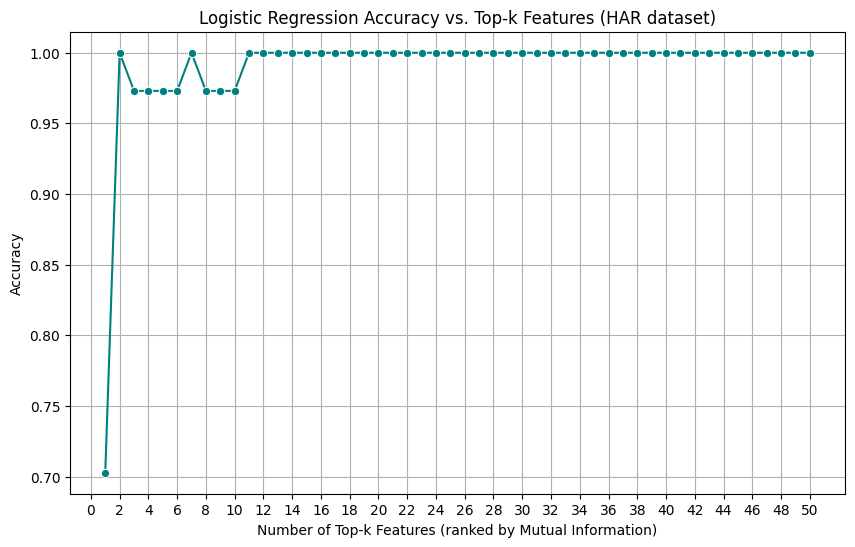

Best accuracy: 1.000 with top 2 features.


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif

# ----------------------------------------------------------------------------
# Step 0: Load your filtered features (after variance/correlation filtering)
# ----------------------------------------------------------------------------
df = pd.read_csv("features_filtered.csv")   # or "features.csv"
meta_cols = ["activity", "trial", "student", "window_idx"]

X = df.drop(columns=[c for c in meta_cols if c in df.columns], errors="ignore")
y = df["activity"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ----------------------------------------------------------------------------
# Step 0.5: Scale Features (important for logistic regression stability)
# ----------------------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# ----------------------------------------------------------------------------
# Step 1: Compute Mutual Information Scores
# ----------------------------------------------------------------------------
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)
feature_ranking = np.argsort(mi_scores)[::-1]  # indices of features sorted by MI

# ----------------------------------------------------------------------------
# Step 2: Evaluate Logistic Regression with Top-k Features
# ----------------------------------------------------------------------------
total_features = X_train.shape[1]
accuracy_list = []

for k in range(1, total_features + 1):
    top_k_features = X_train_scaled.columns[feature_ranking[:k]]
    model = LogisticRegression(max_iter=5000, random_state=42, multi_class="multinomial")
    model.fit(X_train_scaled[top_k_features], y_train)
    y_pred = model.predict(X_test_scaled[top_k_features])
    acc = accuracy_score(y_test, y_pred)
    accuracy_list.append(acc)

# ----------------------------------------------------------------------------
# Step 3: Plot Accuracy vs. Number of Features
# ----------------------------------------------------------------------------
plt.figure(figsize=(10,6))
sns.lineplot(
    x=range(1, total_features + 1),
    y=accuracy_list,
    marker="o",
    color="teal"
)
plt.xlabel("Number of Top-k Features (ranked by Mutual Information)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy vs. Top-k Features (HAR dataset)")
plt.xticks(range(0, total_features + 1, max(1, total_features // 20)))
plt.grid(True)
plt.show()

# ----------------------------------------------------------------------------
# Step 4 (Optional): Print best k
# ----------------------------------------------------------------------------
best_k = np.argmax(accuracy_list) + 1
print(f"Best accuracy: {max(accuracy_list):.3f} with top {best_k} features.")


c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning

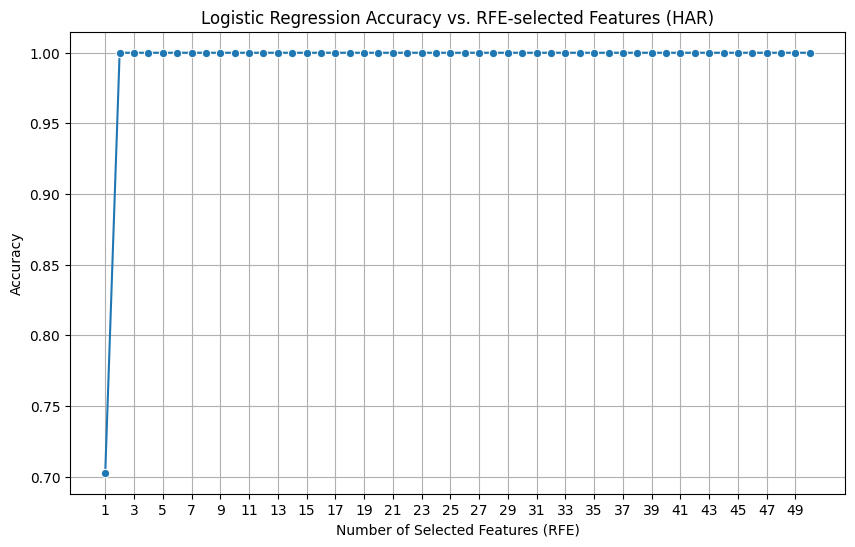

Best accuracy = 1.000 with top 2 features.


In [33]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# --------------------------------------------------------------------
# 0) Load your HAR features
# --------------------------------------------------------------------
df = pd.read_csv("features_filtered.csv")          # or features_filtered.csv
meta_cols = ["activity", "trial", "student", "window_idx"]
X = df.drop(columns=[c for c in meta_cols if c in df.columns], errors="ignore")
y = df["activity"]

# Train/Test split (stratify by activity)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --------------------------------------------------------------------
# 0.5) Scale features (important for Logistic Regression)
# --------------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

# --------------------------------------------------------------------
# 1) RFE curve: accuracy vs number of selected features
#    Note: RFE is expensive if you run it for every k. To keep it reasonable:
#      - set MAX_K (cap)
#      - use step>1 (remove multiple features each iteration)
# --------------------------------------------------------------------
total_features = X_train_scaled.shape[1]
MAX_K = min(total_features, 150)   # cap to speed things up (tune as you like)
STEP  = 0.1                        # can be int (e.g., 5) or fraction (10% per step)

k_values = list(range(1, MAX_K + 1))
rfe_accuracy_list = []

for k in k_values:
    # base estimator (multiclass)
    base_model = LogisticRegression(
        max_iter=5000,
        random_state=42,
        multi_class="multinomial",
        solver="lbfgs"
    )

    # RFE to select top-k features
    selector = RFE(estimator=base_model, n_features_to_select=k, step=STEP)
    selector.fit(X_train_scaled, y_train)

    # selected features
    selected_cols = X_train_scaled.columns[selector.support_]

    # retrain on selected cols and evaluate
    base_model.fit(X_train_scaled[selected_cols], y_train)
    y_pred = base_model.predict(X_test_scaled[selected_cols])
    acc = accuracy_score(y_test, y_pred)
    rfe_accuracy_list.append(acc)

# --------------------------------------------------------------------
# 2) Plot
# --------------------------------------------------------------------
plt.figure(figsize=(10,6))
sns.lineplot(x=k_values, y=rfe_accuracy_list, marker="o")
plt.xlabel("Number of Selected Features (RFE)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy vs. RFE-selected Features (HAR)")
plt.grid(True)
# fewer ticks if many features
if len(k_values) > 40:
    step = max(1, len(k_values)//20)
    plt.xticks(k_values[::step])
plt.show()

# Best k
best_k = k_values[int(np.argmax(rfe_accuracy_list))]
print(f"Best accuracy = {max(rfe_accuracy_list):.3f} with top {best_k} features.")


In [34]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

base_model = LogisticRegression(max_iter=5000, solver="lbfgs", multi_class="multinomial")
rfecv = RFECV(estimator=base_model, step=STEP, cv=StratifiedKFold(5),
              scoring="accuracy", n_jobs=-1)
rfecv.fit(X_train_scaled, y_train)

print("Optimal number of features:", rfecv.n_features_)
best_features = X_train_scaled.columns[rfecv.support_]
print("Best features:", best_features.tolist())


Optimal number of features: 15
Best features: ['accelerometer_y_var', 'accelerometer_z_iqr', 'accelerometer_z_kurt', 'gravity_y_max', 'gravity_z_min', 'gravity_z_var', 'gravity_x_range', 'gyroscope_z_max', 'gyroscope_z_min', 'gravity_xy_corr', 'gyroscope_z_skew', 'gyroscope_mag_iqr', 'gyroscope_z_mean', 'gyroscope_z_median', 'gyroscope_x_fft_dom_mag']


c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Silvia\Desktop\tue\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning